# Classification

## Imports

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import anndata as ad

# import scanpy as sc
# import 

## Load embeddings and metadata

In [ ]:
data = pd.read_csv('../data/raw/dataset_w_partition.csv', index_col=0)
data.index = data['Antibody  Name']
data.drop('Antibody  Name', axis=1, inplace=True)
# display(data)

,Epitope Group,source,D614G,BA.1,BA.2,BA.2.75,BA.5,BQ.1.1,XBB,Heavy chain V gene,Heavy chain J gene,Light chain V gene,Light chain J gene,Heavy chain AA,Light chain AA,clus_vh,clus_vl,connected,partition
Antibody Name,,,,,,,,,,,,,,,,,,,
BD-196,C,WT convalescents,1.93,>10,>10,>10,>10,>10,>10,IGHV1-3,IGHJ6,IGKV2-58,IGKJ1,QVQLVQSGAEVKKPGASVKVSCKASGYTFTSYAMHWVRQAPGQRLE...,DVVMTQSPLSLPVTLGQPASISCRSSQSLVYSDGNTYLNWFQQRPG...,1442,682,0,Validation
BD-218,A,WT convalescents,0.0104,0.00849,0.00937,0.0116,5.26,>10,>10,IGHV4-34,IGHJ1,IGKV3-11,IGKJ5,QVQLQQWGAGLLKPSETLSLTCAVYGGSFSDYFWYWIRQPPGKGLE...,EIVLTQSPATLSLSPGERATLSCRASQSVSSYLAWYQQKPGQAPRL...,1443,508,1,Train
BD-236,A,WT convalescents,0.0173,>10,>10,>10,>10,>10,>10,IGHV3-53,IGHJ6,IGKV1-9,IGKJ4,EVQLVESGGGLIQPGGSLRLSCAASGITVSSNYMSWVRQAPGKGLE...,IQLTQSPSSLSASVGDRVTITCRASQGISSYLAWYQQKPGKAPKLL...,595,591,1,Test
BD-254,C,WT convalescents,0.25,>10,>10,>10,>10,>10,>10,IGHV3-23,IGHJ4,IGLV7-46,IGLJ2,EVQLLESGGGLVQPGGSLRLSCAASGFTLSSYAMSWVRQAPGRGLE...,QAVVTQEPSLTVSPGGTVTLTCGSSTGAVTSGHYPYWFQQKPGQAP...,1444,683,2,Validation
BD-255,B,WT convalescents,0.113,>10,>10,>10,>10,>10,>10,IGHV3-30,IGHJ6,IGKV3-15,IGKJ2,QVQLVESGGGVVQPGRSLRLSCVASGFTFSNYDMHWVRQAPGKGLE...,EIVMTQSPAILSVSPGERATLSCRASQSVTRNLAWYQQKPGQAPRL...,1450,684,3,Validation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BD55-6726,E2.2,SARS convalescents,>10,>10,>10,>10,>10,>10,>10,IGHV1-58,IGHJ2,IGKV3-24,IGKJ1,QMQLVQSGPEVKRPGTSVKVSCEASGFTFSSSAILWVRQPRGQRLE...,EIVLRQSPATVSLSPGERATLSCRASQSVHNYLAWFQQKPGQAPRL...,2157,913,807,Validation
BD55-6727,F2,SARS convalescents,0.293,4.37,>10,>10,>10,>10,>10,IGHV3-11,IGHJ1,IGKV1-39,IGKJ2,QVQLVESGGGLVKPGGSLRLSCAASGFTFSDYYMNWIRQAPGKGLE...,DIQMTQSPSSLSASVGDRVTITCRASQSISNYLNWYQQKPGKAPKL...,2158,456,1,Train
BD55-6728,F1,SARS convalescents,>10,>10,>10,>10,>10,>10,>10,IGHV3-64,IGHJ2,IGKV1-39,IGKJ1,EVQLVESGGGLVQPGGSLRLSCAASGFTFSRFAMHWVRQAPGKGLE...,DIQMTQSPSSLSASLGDRVTITCRASQTISRYLNWYQQKPGKAPKV...,2159,456,1,Train


In [3]:
# Extract the sequencces
heavy_sequences = list(data['Heavy chain AA'])
light_sequences = list(data['Light chain AA'])

# Calculate lengths
heavy_sequence_lengths = [len(seq) for seq in heavy_sequences]
light_sequence_lengths = [len(seq) for seq in light_sequences]

In [8]:
with open('../data/interim/embed_EMS_150M_together', 'rb') as f:
    esm_output = pickle.load(f)

In [25]:
# Create artificial groups for demonstration purposes (12 groups)
np.random.seed(42)
groups = np.array([f'Group {i+1}' for i in range(12)])
group_assignments = np.random.choice(groups, size=100)

# Define a color palette for 12 groups
palette = sns.color_palette("tab20", n_colors=12)
colors = {group: palette[i] for i, group in enumerate(groups)}


In [29]:
# create adata opbejt for pliting

# input: esm_out, and chain link choice.
# chain_choice: togher = linked by <cls>
#
def adata_obej(esm_output,chain_choice = "together"):
    #
    last_layer = list(esm_output['representations'].keys())[0]
    
    if chain_choice == "seperate":
        
        hc_embedding = esm_output['representations'][last_layer][:len(data), :].numpy()
        lc_embedding = esm_output['representations'][last_layer][len(data):, :].numpy()
        X = np.concatenate([hc_embedding, lc_embedding], axis=1)
    else:
        esm_output["representations"][last_layer]
        X = np.array()

    X_mean = X.mean(axis=1)
    adata = ad.AnnData(X_mean)
    adata.obs = data
    return adata

In [31]:
np.array(esm_output["representations"][30])

/tmp/ipykernel_8034/3308765915.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  np.array(esm_output["representations"][30])


array([[[-0.10605053,  0.02301204,  0.04301357, ..., -0.01126355,
         -0.12282217, -0.11911992],
        [-0.1414079 , -0.1395835 ,  0.29613772, ...,  0.19694291,
         -0.2937601 , -0.29372603],
        [ 0.03858059, -0.21888916, -0.07074178, ..., -0.4579386 ,
          0.42126474,  0.23036565],
        ...,
        [ 0.07308101,  0.01573242, -0.11857375, ...,  0.05391761,
         -0.15763064, -0.05084638],
        [ 0.08443235,  0.04791473, -0.1153364 , ...,  0.07456684,
         -0.14049944, -0.12393187],
        [ 0.10094614,  0.04449737, -0.11961777, ...,  0.094143  ,
         -0.19184892, -0.11125339]],

       [[-0.08490734,  0.01971827,  0.02246224, ..., -0.0302068 ,
         -0.06749161, -0.14257234],
        [-0.17269903, -0.21984066,  0.21031815, ...,  0.1440608 ,
         -0.21345307, -0.29182413],
        [ 0.0485351 , -0.30516708, -0.06552676, ..., -0.4562441 ,
          0.3686076 ,  0.3287219 ],
        ...,
        [ 0.07864954, -0.01776661, -0.162007  , ...,  

In [27]:
# Define a color palette for 12 groups
adata = adata_obej(esm_output,"together")
# adata.X  
group_assignments  = np.array(adata.obs["Epitope Group"])
groups = np.unique(np.array(adata.obs["Epitope Group"]))

palette = sns.color_palette("tab20", n_colors=12)
colors = {group: palette[i] for i, group in enumerate(groups)}


/tmp/ipykernel_8034/2124734117.py:16: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  X = np.array(esm_output["representations"][last_layer])


## Plot in different spaces

### PCA

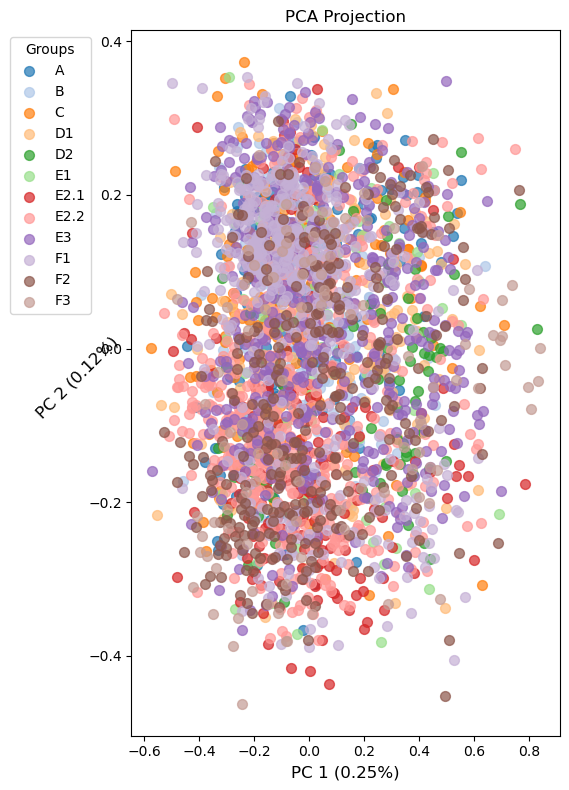

In [8]:
from sklearn.decomposition import PCA

# PCA
n_components_pca = 100
pca = PCA(n_components=n_components_pca)
X_pca = pca.fit_transform(adata.X)

# Explained variance by each component
explained_variance = pca.explained_variance_ratio_[:2]


# Plotting the results
plt.figure(figsize=(10, 8))

# PCA Plot
plt.subplot(1, 2, 1)
for group in groups:
    mask = group_assignments == group
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], label=group, color=colors[group], s=50, alpha=0.7)

# Set the title and axis labels
plt.title('PCA Projection')
plt.xlabel(f'PC 1 ({explained_variance[0]:.2f}%)', fontsize=12)
plt.ylabel(f'PC 2 ({explained_variance[1]:.2f}%)', fontsize=12)

# Rotate the x-axis label
plt.gca().yaxis.label.set_rotation(45)

# Add the legend
plt.legend(title='Groups', bbox_to_anchor=(-0.3, 1), loc='upper left')
# plt.legend(title='Groups', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()  # Adjust layout to fit the rotated label

In [57]:
# from umap import UMAP
# # UMAP
# umap = UMAP(n_components=2, random_state=42)
# X_umap = umap.fit_transform(X)

# # UMAP Plot
# plt.subplot(1, 2, 2)
# for group in groups:
#     mask = group_assignments == group
#     plt.scatter(X_umap[mask, 0], X_umap[mask, 1], label=group, color=colors[group], s=50, alpha=0.7)
# plt.title('UMAP Projection')
# plt.xlabel('UMAP Dimension 1')
# plt.ylabel('UMAP Dimension 2')
# plt.legend(title='Groups', bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.tight_layout()
# plt.show()


ModuleNotFoundError: No module named 'umap'

In [9]:
import scanpy as sc

ModuleNotFoundError: No module named 'scanpy'

In [15]:
with open('../data/interim/embed_EMS_3B_seperate', 'rb') as f:
    esm_output = pickle.load(f)

In [5]:
last_layer = list(esm_output['representations'].keys())[0]
sequneces = len(esm_output['representations'][last_layer])




NameError: name 'esm_output' is not defined

In [90]:


last_layer = list(esm_output['representations'].keys())[0]

# hc_embedding = esm_output['representations'][last_layer][:len(data), :].numpy()
# lc_embedding = esm_output['representations'][last_layer][len(data):, :].numpy()

# X = np.concatenate([hc_embedding, lc_embedding], axis=1)
X = esm_output['representations'][last_layer]

X_mean = X.mean(axis=1)

adata = ad.AnnData(X_mean)
adata.obs = data


# Define a color palette for 12 groups

adata.X
group_assignments  = np.array(adata.obs["Epitope Group"])
groups = np.unique(np.array(adata.obs["Epitope Group"]))

palette = sns.color_palette("tab20", n_colors=12)
colors = {group: palette[i] for i, group in enumerate(groups)}


ValueError: X needs to be of one of <class 'numpy.ndarray'>, <class 'numpy.ma.MaskedArray'>, <class 'scipy.sparse._csr.csr_matrix'>, <class 'scipy.sparse._csc.csc_matrix'>, <class 'scipy.sparse._base.sparray'>, <class 'anndata.compat.AwkArray'>, <class 'h5py._hl.dataset.Dataset'>, <class 'anndata.compat.ZarrArray'>, <class 'anndata.compat.ZappyArray'>, <class 'anndata.abc.CSRDataset'>, <class 'anndata.abc.CSCDataset'>, <class 'anndata.compat.DaskArray'>, <class 'anndata.compat.CupyArray'>, or <class 'anndata.compat.CupySparseMatrix'>, not <class 'torch.Tensor'>.

In [ ]:
from sklearn.decomposition import PCA

# PCA
n_components_pca = 100
pca = PCA(n_components=n_components_pca)
X_pca = pca.fit_transform(adata.X)

# Explained variance by each component
explained_variance = pca.explained_variance_ratio_[:2]


# Plotting the results
plt.figure(figsize=(10, 8))

# PCA Plot
plt.subplot(1, 2, 1)
for group in groups:
    mask = group_assignments == group
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], label=group, color=colors[group], s=50, alpha=0.7)

# Set the title and axis labels
plt.title('PCA Projection')
plt.xlabel(f'PC 1 ({explained_variance[0]:.2f}%)', fontsize=12)
plt.ylabel(f'PC 2 ({explained_variance[1]:.2f}%)', fontsize=12)

# Rotate the x-axis label
plt.gca().yaxis.label.set_rotation(45)

# Add the legend
plt.legend(title='Groups', bbox_to_anchor=(-0.3, 1), loc='upper left')
# plt.legend(title='Groups', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()  # Adjust layout to fit the rotated label

In [4]:
seperate = False
model_size = "35M" #or 150 
tokens = ["_<cls>","_GGGGS","_G"]

ems_data = []

for token in tokens:
    if seperate:
        model_name = 'embed_EMS_' + model_size + '_seperate'
        path = '../../../s184243/AI4ProtEng_AIntibody/data/interim/' +  model_name
        with open(path, 'rb') as f:
            data_esm2 = pickle.load(f)

    else:
        model_name = 'embed_EMS_' + model_size + '_together' + token
        path = '../../../s184243/AI4ProtEng_AIntibody/data/interim/' +  model_name
        with open(path, 'rb') as f:
            print(path)
            data_esm2 = pickle.load(f)
            ems_data.append(data_esm2)

../../../s184243/AI4ProtEng_AIntibody/data/interim/embed_EMS_35M_together_<cls>
../../../s184243/AI4ProtEng_AIntibody/data/interim/embed_EMS_35M_together_GGGGS
../../../s184243/AI4ProtEng_AIntibody/data/interim/embed_EMS_35M_together_G


In [25]:
data

,Epitope Group,source,D614G,BA.1,BA.2,BA.2.75,BA.5,BQ.1.1,XBB,Heavy chain V gene,Heavy chain J gene,Light chain V gene,Light chain J gene,Heavy chain AA,Light chain AA,clus_vh,clus_vl,connected,partition
Antibody Name,,,,,,,,,,,,,,,,,,,
BD-196,C,WT convalescents,1.93,>10,>10,>10,>10,>10,>10,IGHV1-3,IGHJ6,IGKV2-58,IGKJ1,QVQLVQSGAEVKKPGASVKVSCKASGYTFTSYAMHWVRQAPGQRLE...,DVVMTQSPLSLPVTLGQPASISCRSSQSLVYSDGNTYLNWFQQRPG...,1442,682,0,Validation
BD-218,A,WT convalescents,0.0104,0.00849,0.00937,0.0116,5.26,>10,>10,IGHV4-34,IGHJ1,IGKV3-11,IGKJ5,QVQLQQWGAGLLKPSETLSLTCAVYGGSFSDYFWYWIRQPPGKGLE...,EIVLTQSPATLSLSPGERATLSCRASQSVSSYLAWYQQKPGQAPRL...,1443,508,1,Train
BD-236,A,WT convalescents,0.0173,>10,>10,>10,>10,>10,>10,IGHV3-53,IGHJ6,IGKV1-9,IGKJ4,EVQLVESGGGLIQPGGSLRLSCAASGITVSSNYMSWVRQAPGKGLE...,IQLTQSPSSLSASVGDRVTITCRASQGISSYLAWYQQKPGKAPKLL...,595,591,1,Test
BD-254,C,WT convalescents,0.25,>10,>10,>10,>10,>10,>10,IGHV3-23,IGHJ4,IGLV7-46,IGLJ2,EVQLLESGGGLVQPGGSLRLSCAASGFTLSSYAMSWVRQAPGRGLE...,QAVVTQEPSLTVSPGGTVTLTCGSSTGAVTSGHYPYWFQQKPGQAP...,1444,683,2,Validation
BD-255,B,WT convalescents,0.113,>10,>10,>10,>10,>10,>10,IGHV3-30,IGHJ6,IGKV3-15,IGKJ2,QVQLVESGGGVVQPGRSLRLSCVASGFTFSNYDMHWVRQAPGKGLE...,EIVMTQSPAILSVSPGERATLSCRASQSVTRNLAWYQQKPGQAPRL...,1450,684,3,Validation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BD55-6726,E2.2,SARS convalescents,>10,>10,>10,>10,>10,>10,>10,IGHV1-58,IGHJ2,IGKV3-24,IGKJ1,QMQLVQSGPEVKRPGTSVKVSCEASGFTFSSSAILWVRQPRGQRLE...,EIVLRQSPATVSLSPGERATLSCRASQSVHNYLAWFQQKPGQAPRL...,2157,913,807,Validation
BD55-6727,F2,SARS convalescents,0.293,4.37,>10,>10,>10,>10,>10,IGHV3-11,IGHJ1,IGKV1-39,IGKJ2,QVQLVESGGGLVKPGGSLRLSCAASGFTFSDYYMNWIRQAPGKGLE...,DIQMTQSPSSLSASVGDRVTITCRASQSISNYLNWYQQKPGKAPKL...,2158,456,1,Train
BD55-6728,F1,SARS convalescents,>10,>10,>10,>10,>10,>10,>10,IGHV3-64,IGHJ2,IGKV1-39,IGKJ1,EVQLVESGGGLVQPGGSLRLSCAASGFTFSRFAMHWVRQAPGKGLE...,DIQMTQSPSSLSASLGDRVTITCRASQTISRYLNWYQQKPGKAPKV...,2159,456,1,Train


In [6]:
# Get number of proteins in the data
protein_num = int(data.shape[0])


def process_linker(data_esm2, linker_length):
        # Extract representations
        last_layer = list(data_esm2['representations'].keys())[0]
        representations = data_esm2['representations'][last_layer]
        contacts = data_esm2['contacts']

        # Define empty lists
        representations_list = []
        contacts_list = []


        for index in range(protein_num):

                # Remove the zero padding, start, stop tokens, connecting token for the representations
                # rep = <cls> HC "linker" LC <eos>

                # rem end and start 
                representation = representations[index, 1:heavy_sequence_lengths[index]+light_sequence_lengths[index]+2]

                
                # representation = torch.cat((representation[:heavy_sequence_lengths[index]], representation[heavy_sequence_lengths[index]+1:]))

                representation = torch.cat((representation[:heavy_sequence_lengths[index]], representation[heavy_sequence_lengths[index]+linker_length:]))

                representations_list.append(representation)
                
                # Remove start, stop tokens and connecting token for the representations
                # remove from start toekn in both dim
                # Remove start, stop tokens and connecting token for the representations
                # remove from start toekn in both dim
                contact = contacts[index, :heavy_sequence_lengths[index]+light_sequence_lengths[index]+linker_length, :heavy_sequence_lengths[index]+light_sequence_lengths[index]+linker_length]
                
                # contact = torch.cat((contact[:heavy_sequence_lengths[index]], contact[heavy_sequence_lengths[index]+linker_length:]))
                contact = np.delete(contact, slice(heavy_sequence_lengths[index]+1, heavy_sequence_lengths[index] + linker_length + 1), axis=0)

                contact = np.delete(contact, slice(heavy_sequence_lengths[index]+1, heavy_sequence_lengths[index] + linker_length + 1), axis=1)
                contacts_list.append(contact)

        concatenated_embeddings = torch.cat(representations_list, dim=0)
        concatenated_contacts = torch.cat(contacts_list, dim=0)
        data_esm2['representations'][last_layer] = concatenated_embeddings
        data_esm2['contacts']=concatenated_contacts
        return data_esm2



def plot_concetc(some_data):

        plt.matshow(some_data["contacts"][0])
        plt.colorbar()
        return plt.show()


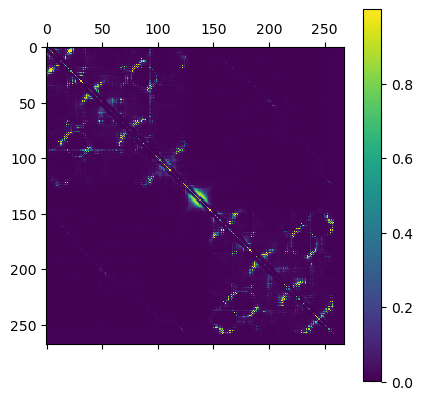

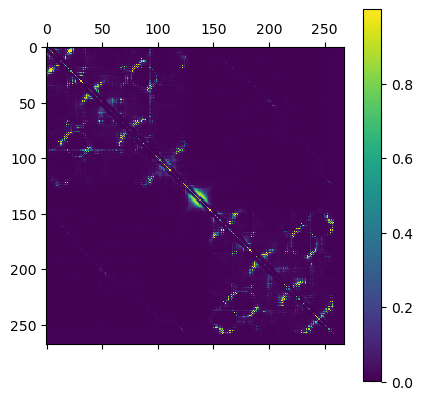

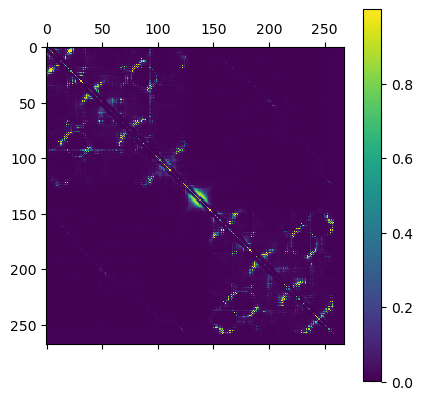

In [7]:

tokens_len = [1,20,15]

# # for index in range(len(tokens)):
# for k in range(2):
#     print(k)

#     if k != 0:
#         ems_data[k] = process_linker(ems_data[k],tokens_len[k])


for index in range(len(tokens)):
    plot_concetc(ems_data[2])


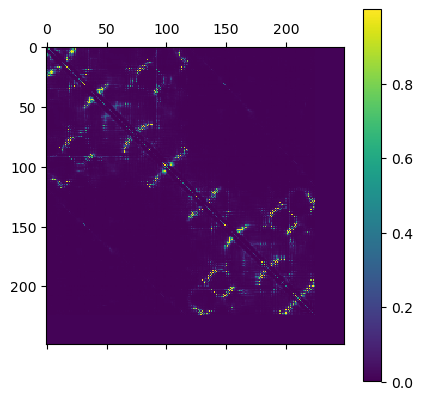

hello


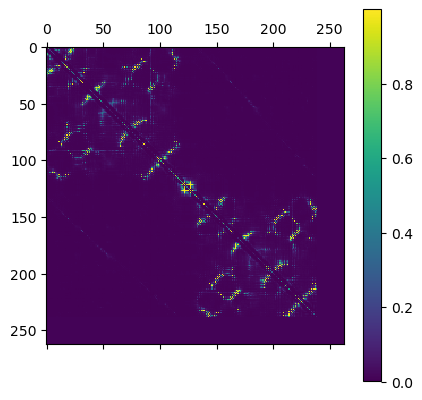

hello


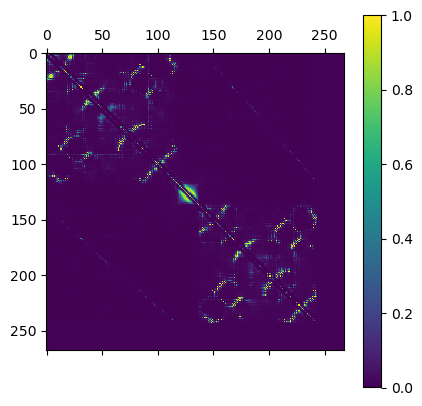

hello


In [9]:
# for i in range(1):
for k in range(3):
    plt.matshow(ems_data[k]["contacts"][2])
    plt.colorbar()
    plt.show()
    print("hello")


In [ ]:
processed_embedding = np.delete(embedding, [start_token_pos, stop_token_pos] + list(range(linker_start, linker_end + 1)), axis=0)


In [81]:
ems_data[0].keys()

dict_keys(['contacts', 'representations'])

: 

In [ ]:
ems_data[1]["contacts"]


# Find maximum dimensions (n, k)
max_n = max(tensor.size(0) for tensor in tensor_list)
max_k = max(tensor.size(1) for tensor in tensor_list)

# Pad tensors to the same shape (max_n, max_k)
padded_tensors = []
for tensor in tensor_list:
    padded = torch.zeros(max_n, max_k)  # Create a zero tensor of max dimensions
    padded[:tensor.size(0), :tensor.size(1)] = tensor  # Copy the original tensor values
    padded_tensors.append(padded)

# Stack the padded tensors to form an m x n x k tensor
stacked_tensor = torch.stack(padded_tensors)  # Shape: (m, n, k)

[tensor([[2.8729e-01, 2.9096e-07, 3.0930e-03,  ..., 8.4780e-03, 8.4780e-03,
          8.4780e-03],
         [2.9096e-07, 9.9254e-01, 7.3334e-07,  ..., 8.4780e-03, 8.4780e-03,
          8.4780e-03],
         [3.0930e-03, 7.3334e-07, 3.7410e-01,  ..., 8.4780e-03, 8.4780e-03,
          8.4780e-03],
         ...,
         [8.4780e-03, 8.4780e-03, 8.4780e-03,  ..., 8.4780e-03, 8.4780e-03,
          8.4780e-03],
         [8.4780e-03, 8.4780e-03, 8.4780e-03,  ..., 8.4780e-03, 8.4780e-03,
          8.4780e-03],
         [8.4780e-03, 8.4780e-03, 8.4780e-03,  ..., 8.4780e-03, 8.4780e-03,
          8.4780e-03]]),
 tensor([[8.9823e-01, 1.2516e-06, 8.6180e-03,  ..., 8.4780e-03, 8.4780e-03,
          8.4780e-03],
         [1.2516e-06, 9.9941e-01, 1.6943e-06,  ..., 8.4780e-03, 8.4780e-03,
          8.4780e-03],
         [8.6180e-03, 1.6943e-06, 6.4661e-01,  ..., 8.4780e-03, 8.4780e-03,
          8.4780e-03],
         ...,
         [8.4780e-03, 8.4780e-03, 8.4780e-03,  ..., 8.4780e-03, 8.4780e-03,
   